### Configuração do ambiente

Para esta atividade de introdução, iremos utilizar um **modelo R-CNN pré-treinado**.

Iremos clonar o repositório do Mask_RCNN para TensorFlow 2 do Github.

[Github](https://github.com/alsombra/Mask_RCNN-TF2)

Descomentar essa sessão na primeira vez que rodar o código para configurar o ambiente.

In [1]:
#!git clone https://github.com/alsombra/Mask_RCNN-TF2

Precisaremos de executar o arquivo **setup.py** dentro do repositório Mask_RCNN-TF2 para realizar a instalação da Mask R-CNN.

Precisaremos chegar até o diretório via código e executar este arquivo.

O caracter % (percentagem) indica que o comando a seguir é em linux. Necessário para não dar warnings (avisos) no código.

In [ ]:
# Comando linux que indica o diretório atual que estamos
#%pwd

In [ ]:
#%cd Mask_RCNN-TF2/

In [ ]:
# Agora estamos no diretório Mask_RCNN_TF2
#%pwd

In [5]:
#!pip install -r requirements.txt

In [6]:
#!python setup.py install

Retornando para o diretório raiz do projeto

In [ ]:
#%cd ..

Instalação do pycocotools para importação do coco.

In [8]:
#!pip install pycocotools

As instalações abaixo com versões específicadas são necessárias para funcionar corretamente.

In [9]:
#!pip install tensorflow==2.9.2
#!pip install tensorflow-gpu==2.9.2

In [10]:
#!pip install numpy==1.23

### Importação das bibliotecas

In [11]:
import os
import sys
import random
import math
import re # regular expressions
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage
import json
import pandas as pd
import tensorflow

c:\Users\DIOGO-PC\Desktop\Estudos\Computer_Vision_Learn\.venv\lib\site-packages\tensorflow\python\keras\engine\training_arrays_v1.py:37: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy.sparse import issparse  # pylint: disable=g-import-not-at-top


In [12]:
skimage.__version__

'0.25.0'

In [13]:
tensorflow.__version__

'2.9.2'

In [14]:
np.__version__

'1.23.0'

In [15]:
# Armazenar o diretório raiz da onde se encontra o repositório
ROOT_DIR = os.path.abspath('./Mask_RCNN-TF2') # Concatenando o diretório atual com o Mask RCNN
ROOT_DIR

'c:\\Users\\DIOGO-PC\\Desktop\\Estudos\\Computer_Vision_Learn\\Segmentacao_de_Imagens\\Segmentacao_de_Instancias\\Mask_RCNN-TF2'

In [16]:
path_exists = False

for i in sys.path:
    if i == ROOT_DIR:
        path_exists = True
        break

# Adicionando o caminho para o repositório do Mask R-CNN caso o path não exista
if not path_exists:
    sys.path.append(ROOT_DIR)

sys.path

['C:\\Users\\DIOGO-PC\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip',
 'C:\\Users\\DIOGO-PC\\AppData\\Local\\Programs\\Python\\Python310\\DLLs',
 'C:\\Users\\DIOGO-PC\\AppData\\Local\\Programs\\Python\\Python310\\lib',
 'C:\\Users\\DIOGO-PC\\AppData\\Local\\Programs\\Python\\Python310',
 'c:\\Users\\DIOGO-PC\\Desktop\\Estudos\\Computer_Vision_Learn\\.venv',
 '',
 'c:\\Users\\DIOGO-PC\\Desktop\\Estudos\\Computer_Vision_Learn\\.venv\\lib\\site-packages',
 'c:\\Users\\DIOGO-PC\\Desktop\\Estudos\\Computer_Vision_Learn\\.venv\\lib\\site-packages\\mask_rcnn-2.1-py3.10.egg',
 'c:\\Users\\DIOGO-PC\\Desktop\\Estudos\\Computer_Vision_Learn\\.venv\\lib\\site-packages\\win32',
 'c:\\Users\\DIOGO-PC\\Desktop\\Estudos\\Computer_Vision_Learn\\.venv\\lib\\site-packages\\win32\\lib',
 'c:\\Users\\DIOGO-PC\\Desktop\\Estudos\\Computer_Vision_Learn\\.venv\\lib\\site-packages\\Pythonwin',
 'c:\\Users\\DIOGO-PC\\Desktop\\Estudos\\Computer_Vision_Learn\\Segmentacao_de_Imagens\\Segmentacao_de_In

Como adicionamos o caminho do repositório no path, conseguimos realizar a importação de alguns arquivos que estão dentro do repositório e que iremos utilizar.

In [17]:
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn.model import log

Iremos adicionar outro path, no caso, dos exemplos (samples)

In [18]:
ROOT_DIR_COCO_SAMPLES = os.path.abspath('./Mask_RCNN-TF2/samples/coco/')

path_coco_samples_exists = False

for i in sys.path:
    if i == ROOT_DIR_COCO_SAMPLES:
        path_coco_samples_exists = True
        break


# Adicionando o caminho para os exemplos caso não exista
if not path_coco_samples_exists:
    sys.path.append(ROOT_DIR_COCO_SAMPLES)

sys.path

['C:\\Users\\DIOGO-PC\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip',
 'C:\\Users\\DIOGO-PC\\AppData\\Local\\Programs\\Python\\Python310\\DLLs',
 'C:\\Users\\DIOGO-PC\\AppData\\Local\\Programs\\Python\\Python310\\lib',
 'C:\\Users\\DIOGO-PC\\AppData\\Local\\Programs\\Python\\Python310',
 'c:\\Users\\DIOGO-PC\\Desktop\\Estudos\\Computer_Vision_Learn\\.venv',
 '',
 'c:\\Users\\DIOGO-PC\\Desktop\\Estudos\\Computer_Vision_Learn\\.venv\\lib\\site-packages',
 'c:\\Users\\DIOGO-PC\\Desktop\\Estudos\\Computer_Vision_Learn\\.venv\\lib\\site-packages\\mask_rcnn-2.1-py3.10.egg',
 'c:\\Users\\DIOGO-PC\\Desktop\\Estudos\\Computer_Vision_Learn\\.venv\\lib\\site-packages\\win32',
 'c:\\Users\\DIOGO-PC\\Desktop\\Estudos\\Computer_Vision_Learn\\.venv\\lib\\site-packages\\win32\\lib',
 'c:\\Users\\DIOGO-PC\\Desktop\\Estudos\\Computer_Vision_Learn\\.venv\\lib\\site-packages\\Pythonwin',
 'c:\\Users\\DIOGO-PC\\Desktop\\Estudos\\Computer_Vision_Learn\\Segmentacao_de_Imagens\\Segmentacao_de_In

In [19]:
# Caso o path for adicionado corretamente, não dará erros na importação
import coco

In [20]:
MODEL_DIR = os.path.join(ROOT_DIR, 'logs') # Este diretório só existirá após a rede neural estiver em funcionamento
IMAGE_DIR = os.path.join(ROOT_DIR, 'images') # Contém várias imagens de teste para utilizarmos

print(MODEL_DIR)
print(IMAGE_DIR)

c:\Users\DIOGO-PC\Desktop\Estudos\Computer_Vision_Learn\Segmentacao_de_Imagens\Segmentacao_de_Instancias\Mask_RCNN-TF2\logs
c:\Users\DIOGO-PC\Desktop\Estudos\Computer_Vision_Learn\Segmentacao_de_Imagens\Segmentacao_de_Instancias\Mask_RCNN-TF2\images


### Download do Dataset

O download do dataset pode ser realizado através desse link do Google Drive:

[Baixar dataset de balões](https://drive.google.com/file/d/1mkhPqgNggwinrMHDkzwPd5Ug7WDM7c4A/view?usp=drive_link)

Após o download, cole a pasta com os dados no diretório atual do arquivo e nomeie como "ballon".

**Explicação do dataset**

Para ensinar as redes neurais no contexto de detecção e segmentação de objetos, temos que ter 2 tipos de arquivos:
- A imagem em si.
- Um arquivo (no nosso caso, json) que armazena para cada um dos arquivos onde estão os balões na imagem.

Isso é chamado de **Aprendizagem Supervisionada**, no qual a rede neural terá as posições dos balões nas imagens de treinamento para que a rede neural consiga fazer previsões com outras imagens.


### Carregamento do Dataset

Iremos utilizar a classe Dataset do mrcnn do arquivo "utils.py" para facilitar a leitura e extração dos valores do json.

Iremos sobrescrever o método *load_object* que faz a leitura do arquivo json para extrair as anotações (posições x e y). 

Também iremos sobrescrever o método *load_mask* que gera as máscaras em bitmap para cada objeto na imagem por meio do desenho dos polígonos que são desenhados na imagem com base no conjunto de coordenadas descritos no json.

In [21]:
class DatasetPersonalizado(utils.Dataset):
    def load_object(self, dataset_dir, subset, nome_annotation="via_region_data.json"):
        """Carrega um subconjunto do dataset Balloon.
        dataset_dir: Diretorio raíz do dataset.
        subset: Subconjunto a ser carregado: train (treinamento) ou val (validação)
        """
        # Adiciona as classes. Nesse exemplo, temos apenas uma classe para adicionar.
        self.add_class("objetos", 1, "balloon")

        # Escolhe se é o dataset de Treinamento ou Validação
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Carrega as anotações (annotations)
        # VGG Image Annotator (Até a verão 1.6) salva cada imagem no formato:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # O que mais interessa para nós são as coordenadas x e y de cada região
        # Obs: No VIA 2.0, as regiões são salvas em forma de lista ao invés de dicionario.
        annotations = json.load(open(os.path.join(dataset_dir, nome_annotation)))
        annotations = list(annotations.values())  # não precisa das dict keys

        # A ferramenta VIA salva as imagens em JSON mesmo que elas não contenham nenhuma anotação. Então, pulamos as imagens não anotadas.
        annotations = [a for a in annotations if a['regions']]

        contagem = 0
        # Adiciona as imagens
        for a in annotations:
            # Pega as coordenadas x e y dos pontos dos poligonos que formam o contorno de cada instância do objeto.
            # Eles são armazenadas em shape_attributes (para visualizar, abra o arquivo json)
            # A condição if é necessária para que o código suporte anotações geradas pelas versões 1.x e 2.x da VIA.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]

            # A função load_mask() vai precisar do tamanho da imagem para que possa converter os polígonos em mascaras.
            # Infelizmente, o VIA não inclui isso no JSON, então devemos ler a imagem manualmente e gerar essas máscaras.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            contagem = contagem+1

            self.add_image("objetos",
                image_id=a['filename'],  # usa o nome do arquivo como id unico da imagem
                path=image_path,
                width=width, height=height,
                polygons=polygons)

        print("Imagens "+subset+": " + str(contagem))

    def load_mask(self, image_id):
        """Gera as mascaras das instâncias para a imagem.
       Returna:
        masks: Uma array booleana de formato/shape [height, width, instance count] com 1 mascara por instancia.
        class_ids: uma array de 1D contendo os IDs das mascaras das instancias.
        """
        # Se não for uma imagem de conjunto de dados do balão (balloon dataset), delegue à classe ascendente.
        image_info = self.image_info[image_id]
        #print(image_info)
        if image_info["source"] != "objetos":
            return super(self.__class__, self).load_mask(image_id)

        # Converte os poligonos em uma mascara bitmap com shape  [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)

        # Agora será calculado a máscara da instância. para cada pixel da imagem, classificará como pertencente à classe ou não
        for i, p in enumerate(info["polygons"]):
            # Pega os indices dos pixels dentro dos poligonos e define eles como = 1 (cor branca), caso contrário continuará valor 0 (cor preta)
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'], mask.shape) # passamos o .shape também como 3ª parâmetro para evitar possíveis erros

            ## Obs: para esse dataset a anotação foi feita usando formas poligonais.
            ## Entretanto, caso tenha usado outras formas pela ferramenta VIA (circulos e elipses) deverá especificar isso no código, ficando assim
            #if p['name'] == 'polygon':
            #  rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'], mask.shape)
            #elif p['name'] == 'circle':
            #  rr, cc = skimage.draw.circle(p['cx'], p['cy'], p['r'])
            #else:
            #  rr, cc = skimage.draw.ellipse(p['cx'], p['cy'], p['rx'], p['ry'], rotation=np.deg2rad(p['theta']))

            # Para as coordenadas específicas do polígino, atribuí o valor 1 para ficar com o fundo branco na imagem
            mask[rr, cc, i] = 1

        # Retorna a mascara e a array dos IDs das classes de cada instancia.
        # Como nesse exemplo temos uma classe apenas, retornamos uma array composta de 1s
        return mask.astype(bool), np.ones([mask.shape[-1]], dtype=np.int32)

    # Função que retorna o caminho da imagem
    def image_reference(self, image_id):
        """Retorna o caminho da imagem."""
        info = self.image_info[image_id]
        if info["source"] == "objetos":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

**Preparando o conjunto de dados**

In [22]:
PATH_DATASET = os.path.join('balloon')
ANNOTATION_NAME = 'via_region_data.json'

# Conjunto de treinamento
dataset_train = DatasetPersonalizado()
dataset_train.load_object(PATH_DATASET, 'train', ANNOTATION_NAME)
dataset_train.prepare() # Preparar a base de dados para utilização

# Conjunto de validação
dataset_val = DatasetPersonalizado()
dataset_val.load_object(PATH_DATASET, 'val', ANNOTATION_NAME)
dataset_train.prepare() # Preparar a base de dados para utilização

Imagens train: 61
Imagens val: 13


### Verificação/visualização do dataset (visualizando os retornos da classe DatasetPersonalizado)

In [23]:
# Função para exibir imagem
def exibir_imagem(image):
    plt.figure(figsize=(12,6))
    plt.axis('off')
    plt.imshow(image, cmap='gray')

Temos 61 imagens no total, iremos pegar a primeira imagem para visualizar a máscara.

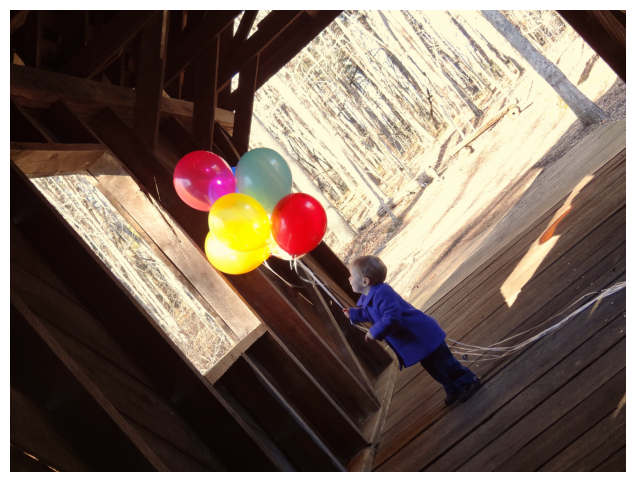

In [24]:
img_id = 7
img = dataset_train.load_image(img_id)
exibir_imagem(img)

[1 1 1 1 1 1]
(1536, 2048, 6)
Classes: ['BG', 'balloon']


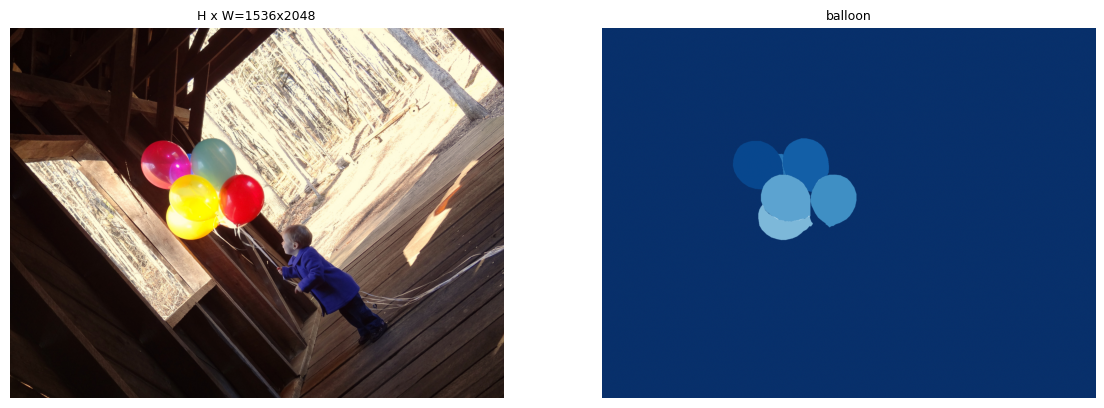

In [25]:
img_mask, class_ids = dataset_train.load_mask(img_id)

# Ids das classes de objetos detectados (no caso, só haverá id 1 pois só queremos detectar balões)
print(class_ids)

# Resolução de 1536x2048 pixels, onde há 6 máscaras (no caso, 6 máscaras para cada balão detectado)
# Ou seja, aqui temos 6 imagens diferentes que representam as máscaras de cada um dos balões
print(img_mask.shape)

print("Classes:", dataset_train.class_names)

visualize.display_top_masks(img, # Imagem original
                            img_mask, # Máscaras
                            class_ids, # Ids das classes
                            dataset_train.class_names, # Nome das classes
                            1) # Exibir apenas uma imagem com todas as máscaras

Temos os *bounding boxes* (caixas delimitadoras) relacionados ao balões que forma detectados (y1, x1, y2, x2).

In [26]:
# bbox => bounding boxes
bbox = utils.extract_bboxes(img_mask)
bbox

array([[ 468,  542,  671,  751],
       [ 457,  748,  681,  941],
       [ 522,  730,  610,  763],
       [ 608,  864,  828, 1056],
       [ 608,  659,  804,  865],
       [ 733,  648,  881,  874]])

In [27]:
print('Imagem', img_id, dataset_train.image_reference(img_id))
log('image', img) # Imagem original, pixels entre 0 e 255
log('image', img_mask) # Máscaras da imagem, pixels entre 0 e 1 (preto e branco)
log('class_ids', class_ids)
log('bbox', bbox)

Imagem 7 balloon\train\15717689633_5f7f78c28e_k.jpg
image                    shape: (1536, 2048, 3)       min:    0.00000  max:  255.00000  uint8
image                    shape: (1536, 2048, 6)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (6,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (6, 4)                min:  457.00000  max: 1056.00000  int32


Podemos visualizar a segmentação de uma das imagens do conjunto de treino.

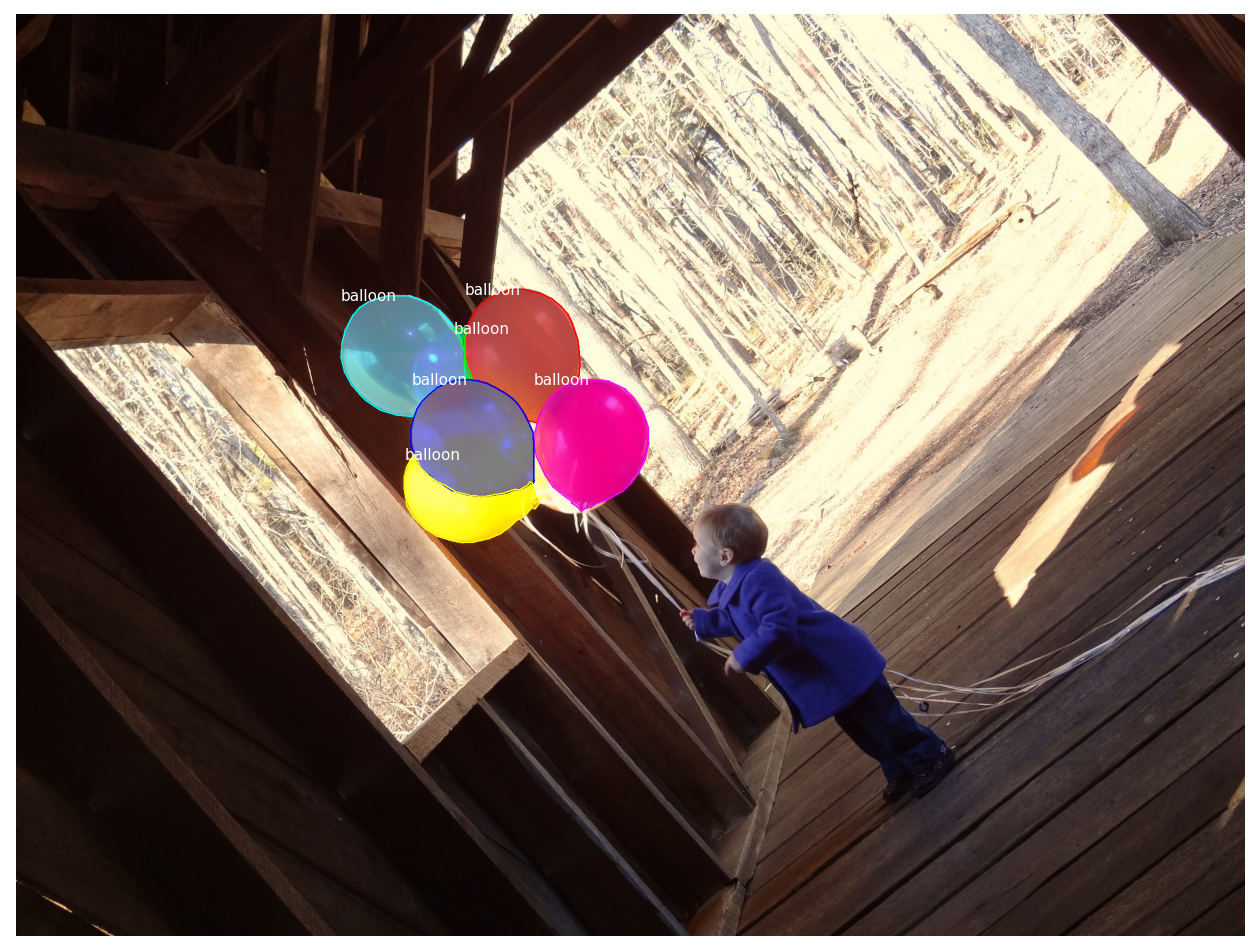

In [28]:
visualize.display_instances(img, 
                            bbox, 
                            img_mask, 
                            class_ids, 
                            dataset_train.class_names, 
                            show_bbox=False)

Para visualizar cada um dos segmentos detectados com a função display_images, precisamos realizar a transposição do array img_mask (linhas se tornarão colunas e colunas se tornarão linhas).

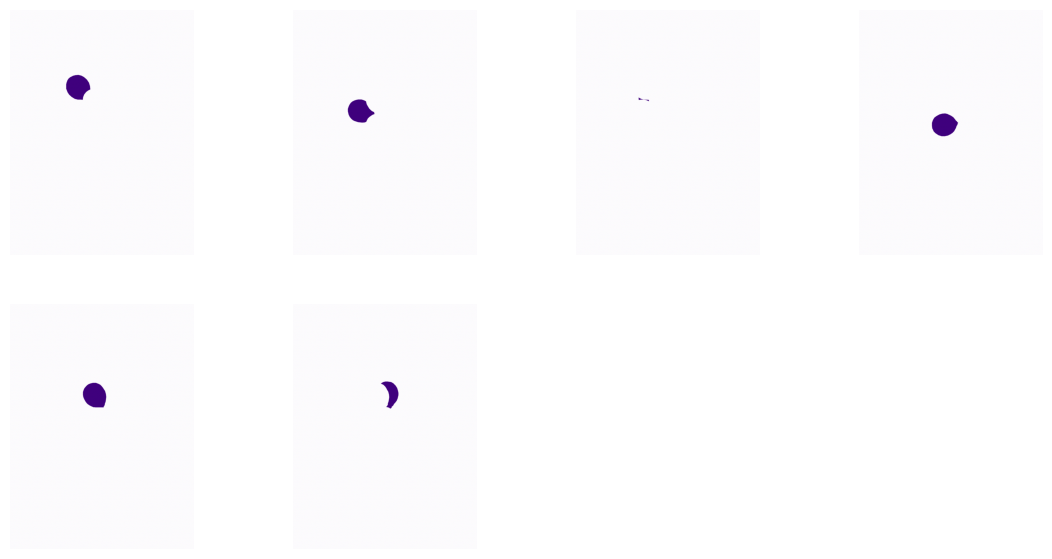

In [29]:
visualize.display_images(np.transpose(img_mask), cmap='Purples')

### Configurações da rede neural

In [30]:
class ConfigRede(Config): # Herdando da classe Config do Mask R-CNN
    NAME = 'balloon' # Nome para identificar essa configuração da rede neural
    IMAGES_PER_GPU = 1
    NUM_CLASSES = len(dataset_train.class_names) # 2 classes (BG e balloon)
    STEPS_PER_EPOCH = 100 # Número de passos que serão utilizados no treinamento (padrão 100)
    DETECTION_MIN_CONFIDENCE = 0.9 # Indica que irá pular as detecções com menos de 90% de confiança

config = ConfigRede()
config.display() # Visualizando a configuração da rede neural


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

### Carregamento dos pesos

De fato, para que carregar os pesos se iremos treinar a rede neural do zero? Iremos realizar a **transferência de aprendizagem**.

**Transferência de aprendizagem**

Iremos trabalhar com o dataset *coco*, porém somente com a parte da rede neural que faz a extração das características mais básicas das imagens, como por exemplo, as bordas e os contornos, e assim por diante.

A nossa rede neural vai utilizar toda a estrutura dos pesos do coco e vamos somente adicionar algumas camadas no final para de fato trabalharmos apenas com o **reconhecimento dos balões**.

Se fizermos literalmente do zero, seria muito demorado realizar o treinamento da rede neural.

In [31]:
# Caminho do arquivo que armazena os pesos da rede neural
COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'mask_rcnn_coco.h5')

In [32]:
# Caso ainda não existir os pesos, realiza o download
if not os.path.exists(COCO_MODEL_PATH): 
    utils.download_trained_weights(COCO_MODEL_PATH)

Também é possível trabalhar com mais de uma base de dados, como por exemplo, da *ImageNet*.

No parâmetro **exclude**:
- Estamos carregando pesos do modelo 'coco', porém estamos pulando estas camadas do array 'exclude' pois estas camadas servem para detecções de mais de 2 objetos, no caso apenas queremos detectar balões.

Com a função *find_last* é possível adquirir o último modelo treinado. Por exemplo, caso o computador seja desligado e em algum outro momento seja necessário continuar o treinamento anterior, é possível resgatar os últimos pesos treinados pelo modelo. Dessa forma é possível extrar o treinamento em um momento posterior.

In [33]:
def carrega_modelo_treinamento(config, inicia_com = 'coco', model_path = ''):
    model = modellib.MaskRCNN(mode='training',
                              config = config,
                              model_dir=model_path)
    
    if inicia_com == 'coco':
        model.load_weights(COCO_MODEL_PATH,
                           by_name=True,
                           exclude=['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])
    elif inicia_com == 'imagenet':
        model.load_weights(model.get_imagenet_weights(), # Carregando os pesos da base de dados do ImageNet
                           by_name=True)
    elif inicia_com == 'last': # Caso queira continuar o treinamento anterior
        if model_path == '':
            model_path = model.find_last() # Adquire o último modelo que foi treinado
        model.load_weights(model_path, by_name=True) # Carrega os pesos anteriores do modelo
    else:
        raise Exception('Base de dados não encontrada')

    return model

In [34]:
model = carrega_modelo_treinamento(config, 'coco')

### Treinamento do modelo

Parâmetro **layers='heads'**:
- Indica que será treinado apenas as camadas de saída do modelo, para de fato fazermos a detecção dos balões.

As primeiras camadas da rede neural são responsáveis pela extração das características básicas da imagem, enquanto que as últimas camadas são responsáveis por aprender a identificar o objeto que nós queremos. Portanto, iremos utilizar as camadas convolucionais do modelo (primeiras camadas pré-treinadas), porém, precisaremos ajustar a sua saída, para isto basta pegarmos apenas as camadas de processamento do modelo e treinamos uma nova camada de saída. É aqui que acontece a parte da **Transferência de aprendizagem**.

Parâmetro **all**:
- Irá treinar toda a estrutura da rede neural, consequentemente demorará muito mais para realizar o treinamento do modelo.

#### **OBS IMPORTANTE.** 

Para funcionar corretamente o treinamento:
- O diretório até o notebook atual não deve ter caracteres especiais (acentos e pontuações).
- Foi necessário uma modificação no arquivo *utils.py* abaixo:

```py
    if image.dtype == bool:
        order = 0
```

Esta modificação foi necessária pois as máscaras são um array de booleanos, onde é necessário passar o parâmetro order como 0 (zero) para a função *skimage.transform.resize*.

Caso queira modificar o código fonte do *mrcnn*, **não esqueça de limpar o cache** (*_pycache_*), do contrário as modificações não terão efeito.

In [ ]:
start_time = time.time()

model.train(dataset_train, # Dataset de treino
            dataset_val, # Dataset de validação
            learning_rate=config.LEARNING_RATE, # Learning rate definida na configuração da rede neural (acima)
            epochs=25, # Quantidade de épocas
            layers='heads') # Aqui indica que apenas irá ser treinada a saída do modelo

end_time = time.time()
end_time = round((end_time - start_time) / 60,
                  2) # Mostrará apenas 2 casas decimais

print('Tempo de treinamento', end_time)


Starting at epoch 0. LR=0.001

Checkpoint Path: balloon20250112T0437\mask_rcnn_balloon_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistributed)
mrcnn

c:\Users\DIOGO-PC\Desktop\Estudos\Computer_Vision_Learn\.venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/25


c:\Users\DIOGO-PC\Desktop\Estudos\Computer_Vision_Learn\.venv\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
c:\Users\DIOGO-PC\Desktop\Estudos\Computer_Vision_Learn\.venv\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training/

  2/100 [..............................] - ETA: 19:29 - batch: 0.5000 - size: 1.0000 - loss: 35.7572 - rpn_class_loss: 2.5427 - rpn_bbox_loss: 17.6113 - mrcnn_class_loss: 7.0538 - mrcnn_bbox_loss: 7.4845 - mrcnn_mask_loss: 1.0650      

O treinamento é muito demorado aqui, portanto, iremos utilizar alguns pesos do material do curso.

In [ ]:
model.find_last()